In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

First, we import the input and output datasets.

In [2]:
in_data_1 = pd.read_csv('https://drive.google.com/uc?id=19xQWXaqtF685BP9-awsRgNv77udv0-sx')
in_data_2 = pd.read_csv('https://drive.google.com/uc?id=19vESYitHjVR2nEiMgLOiEVlIr4LOTGX4')
in_data_3 = pd.read_csv('https://drive.google.com/uc?id=1FJACauRxbNuilgXm-eg7s-K4HM1sAoeA')
in_data = pd.concat([in_data_1,in_data_2,in_data_3],axis = 0,ignore_index = True)
out_data = pd.read_csv('https://drive.google.com/uc?id=19i5CWvm9-wNXVwF-wiBODty0mPdupyLQ')['reod']

The next cell specifies the training, test and prediction datasets chosen randomly. 

In [3]:
train_fraction = 0.9
test_fraction = 1 - train_fraction

#Randomly choose elements for each sub-dataset

train_index = np.random.choice(range(in_data.shape[0]), size = int(train_fraction*in_data.shape[0]),replace = False)
test_index = np.random.choice(np.delete(range(in_data.shape[0]),train_index), size = int(test_fraction*in_data.shape[0]),replace = False)

Here we reshape the dataset to be fed the DNN

In [4]:
X_train = in_data.iloc[train_index].values
Y_train = out_data[train_index].values
X_test = in_data.iloc[test_index].values
Y_test = out_data[test_index].values

# Rescale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# Prepare Data to be fed the DNN
num_classes = 3
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (758969, 53, 1, 1)
Y_train shape: (758969, 3)
X_test shape: (84329, 53, 1, 1)
Y_test shape: (84329, 3)


Let us create an instance of Keras' `Sequential()` class, called `model`. As the name suggests, this class allows us to build DNNs layer by layer. We use the `add()` method to attach layers to our model. For the purposes of our introductory example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
# training parameters
batch_size = 128
epochs = 100

def create_CNN():
    
    model = Sequential()
    model.add(Input(shape=(53, 1, 1)))
    
    model.add(Conv2D(128, (5, 1),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 1)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (5, 1),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 1)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use `Adam()` or any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
# add early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# use RMSprop optimizer
optimizer = keras.optimizers.SGD(learning_rate=0.005)

def compile_model(optimizer=optimizer):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


We train our DNN in minibatches, the advantages of which were explained in Sec. IV. Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. 
Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# create the deep neural net
model_CNN=compile_model()

# train CNN and store training info in history
history=model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),callbacks=[early_stop])

Epoch 1/100
5930/5930 [==============================] - 50s 8ms/step - loss: 1.4645 - accuracy: 0.4421 - val_loss: 1.3996 - val_accuracy: 0.4551
Epoch 2/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.3758 - accuracy: 0.4549 - val_loss: 1.3565 - val_accuracy: 0.4552
Epoch 3/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.3351 - accuracy: 0.4567 - val_loss: 1.3175 - val_accuracy: 0.4592
Epoch 4/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.2990 - accuracy: 0.4585 - val_loss: 1.2832 - val_accuracy: 0.4583
Epoch 5/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.2670 - accuracy: 0.4599 - val_loss: 1.2558 - val_accuracy: 0.4599
Epoch 6/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.2388 - accuracy: 0.4607 - val_loss: 1.2261 - val_accuracy: 0.4650
Epoch 7/100
5930/5930 [==============================] - 46s 8ms/step - loss: 1.2139 - accuracy: 0.4615 - val_loss: 1.2021 -

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

In [8]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2636/2636 [==============================] - 8s 3ms/step - loss: 1.0086 - accuracy: 0.4880

Test loss: 1.0085830688476562
Test accuracy: 0.48802903294563293


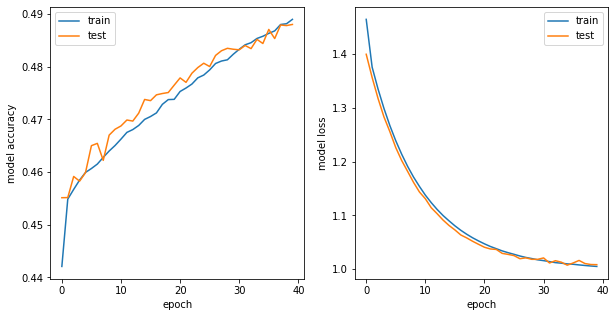

In [9]:
# look into training history
fig, ax = plt.subplots(1,2, figsize = (10,5))

# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='best')

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best')

plt.show()

Finally we import the input data from which we want to predict the output for the challenge, treat it the way we did with the other and then use the DNN to predict the outcome to submit. 

In [10]:
chal_in_data_1 = pd.read_csv('https://drive.google.com/uc?id=1Zlh9JkPFc7vmudIyT0-UcloOUkP5tcY8')
chal_in_data_2 = pd.read_csv('https://drive.google.com/uc?id=1qNDlxFtF4ZEjcEl7NWo-zMft8ifTfabP')
chal_in_data_3 = pd.read_csv('https://drive.google.com/uc?id=1VZdfOQNI64syZd1-VkyKr0sNDeztAFEb')
chal_in_data = pd.concat([chal_in_data_1,chal_in_data_2,chal_in_data_3],axis = 0,ignore_index = True).values
IDs = np.arange(1e6,1e6 + chal_in_data.shape[0],dtype = int)

Here we predict the output and create the corresponding dataframe.

In [11]:
X_chal = scaler.transform(chal_in_data)
X_chal = X_chal.reshape(X_chal.shape[0], X_chal.shape[1], 1, 1)
Y_chal = model_CNN.predict(X_chal)
chal_classes = np.array([[0,1,-1] for x in range(Y_chal.shape[0])])
chal_best = np.argmax(Y_chal,axis = 1)
chal_results= np.array([chal_classes[i,chal_best[i]] for i in range(len(chal_best))])
chal_preds = pd.DataFrame(np.vstack([IDs,chal_results]).transpose())
chal_preds.columns = ['ID','reod']
chal_preds

27682/27682 [==============================] - 50s 2ms/step


,ID,reod
0,1000000,1
1,1000001,1
2,1000002,0
3,1000003,-1
4,1000004,0
...,...,...
885794,1885794,-1
885795,1885795,0
885796,1885796,0
885797,1885797,0


In [12]:
chal_preds.to_csv('output_test.csv',index=False)